# Naive Bayes 
Construct and test a Naive Bayes model with scikit-learn.

## Modeling objective

The modeling objective is to build and test a Naive Bayes model that uses banking data to predict whether a customer will churn. If a customer churns, it means they left the bank and took their business elsewhere. Predicting customers who are likely to churn, then measurements to retain them could be taken on time. For example, promotions, discounts, or other incentives to boost customer satisfaction.

### Target variable

The target variable is called `Exited`. This is a Boolean value that indicates whether or not a customer left the bank (0 = did not leave, 1 = did leave). For each customer, the model will predict whether they should have a 0 or a 1 in the `Exited` column.

### IMPORTANT: Model design

This is a classification task, because we are trying to predict on a binary class. Naive Bayes often works well for this kind of task. However, recall that there are several different implementations of the Naive Bayes algorithm in scikit-learn, and each assumes that all of your predictor variables are of a single type (e.g., Gaussian for continuous variables, Bernoulli for binary variables, etc.). 

The data has all different types of predictor variables! Data is never perfect and sometimes the data breaks the assumptions of your model. In practice, do the best with what its available. 

To build the best possible Naive Bayes model, each variable should be treated according to their different types and distributions, and then each conditional probability combined to get the final prediction for each observation. This notebook showcases a simplified solution.

This model uses the `GaussianNB` classifier. This implementation assumes that all of the variables are continuous _and_ that they have a Gaussian (i.e., normal) distribution. The data doesn't perfectly adhere to these assumptions, but a Gaussian model may still yield usable results, even with imperfect data.

## Import statements

Import all libraries and extensions required. That is, numpy and pandas for operations, and matplotlib for plotting.

Also import the `GaussianNB` from the `sklearn.naive_bayes` module. From the same modulre there is also other implementations of Naive Bayes. Refer to the [documentation](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.naive_bayes) for details.

Also import some evaluation metrics from `sklearn.metrics` and some functions that will help to generate and plot a confusion matrix.

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## Read in the data

Use the dataframe that was already made in the previous notebook. Significant operations:

* Dropped the `RowNumber`, `CustomerId`, `Surname`, and `Gender` columns
* Dummy encoded the `Geography` column to convert categorical to Boolean
* Engineered a new feature called `Loyalty`, by dividing each customer's tenure by their age

In [17]:
churn_df = pd.read_csv('churn_df.csv')
churn_df.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Loyalty,Geography_Germany,Geography_Spain
0,619,42,2,0.00,1,1,1,101348.88,1,0.047619,0,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0.024390,0,1
2,502,42,8,159660.80,3,1,0,113931.57,1,0.190476,0,0
3,699,39,1,0.00,2,0,0,93826.63,0,0.025641,0,0
4,850,43,2,125510.82,1,1,1,79084.10,0,0.046512,0,1


## Check the class balance

Before modeling, check the class balance of the `Exited` column, the target variable.

In [18]:
# Check class balance
churn_df['Exited'].value_counts()

Exited
0    7963
1    2037
Name: count, dtype: int64

The class is split roughly 80/20. In other words, ~20% of the people in this dataset churned. This is an unbalanced dataset, but it's not extreme. 

The Naive Bayes formula depends on class priors _(P(c))_ to make predictions. Because of this, performing class balancing (e.g., upsampling or downsampling) would change those terms in a way that would no longer reflect the real-world distribution of the data.

For these reasons, proceed without altering the class balance of the target variable.

## Drop dependent variables

The Naive Bayes models operate best when there's conditional independence between the predictor variables. Previously, a feature called `Loyalty` was engineered by dividing `Tenure` by `Age`. Because this new feature is just the quotient of two existing variables, it's no longer conditionally independent. Therefore, drop `Tenure` and `Age` to help adhere to the assumptions of our model.

In [19]:
# Drop Tenure and Age variables
churn_df = churn_df.drop(['Tenure', 'Age'], axis=1)
churn_df.head()

,CreditScore,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Loyalty,Geography_Germany,Geography_Spain
0,619,0.00,1,1,1,101348.88,1,0.047619,0,0
1,608,83807.86,1,0,1,112542.58,0,0.024390,0,1
2,502,159660.80,3,1,0,113931.57,1,0.190476,0,0
3,699,0.00,2,0,0,93826.63,0,0.025641,0,0
4,850,125510.82,1,1,1,79084.10,0,0.046512,0,1


## Split the data

Split the data into features and target variable, and into training data and test data. Do this by using the `train_test_split()` function. Put 25% of the data into the test set, and use the remaining 75% to train the model.

Notice below the argument `stratify=y`. Given the case that the master data has a class split of 80/20, stratifying ensures that this proportion is maintained in both the training and test data. `=y` tells the function that it should use the class ratio found in the `y` variable (the target).

The less data overall, and the greater the class imbalance, the more important it is to stratify when spliting the data. Without stratify, then the function would split the data randomly, and the minoruty class would be lost in the test data, which means no effective evaluation for the model. Moreover, identifiying what went wrong would be hardly possible.

Set a random seed for reproductibility.

In [20]:
# Define the y (target) variable
y = churn_df['Exited']

# Define the X (predictor) variables
X = churn_df.copy()
X = X.drop('Exited', axis=1)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, \
                                                    stratify=y, random_state=42)

## Modeling

### 1. Unscaled data

The modeling process will begin with fitting the model to the training data, and then using the model to make predictions on the test data. 

In [21]:
# Fit the model
gnb = GaussianNB()
gnb.fit(X_train, y_train)

# Get the predictions on test data
y_preds = gnb.predict(X_test)

Check model performamce using the evaluation metrics.

In [22]:
print('Accuracy:', '%.3f' % accuracy_score(y_test, y_preds))
print('Precision:', '%.3f' % precision_score(y_test, y_preds))
print('Recall:', '%.3f' % recall_score(y_test, y_preds))
print('F1 Score:', '%.3f' % f1_score(y_test, y_preds))

Accuracy: 0.796
Precision: 0.000
Recall: 0.000
F1 Score: 0.000


C:\Users\adria\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


The precision, recall, and F1 scores are all zero. Consider the precision formula: 
</br>  
$$precision = \frac{\text{true positives}}{\text{false positives + true positives}}$$
  </br> 

There are two ways for the model to have a precision of zero. The first is if the numerator is zero, which would mean that the model didn’t predict any true positives. 

The second is if the denominator is also zero, which would mean that the model didn’t predict any positives at all. Dividing by zero results in an undefined value, but scikit-learn will return a value of zero in this case. Depending on the modeling environment, there might be a warning about a denominator of zero. 

Check which situation is occurring here. Call `np.unique()` on the model's predictions and if it doesn't return an array containing `[0, 1]`, then it's not predicticting any churned customers.

In [23]:
# Check unique values in predictions
np.unique(y_preds)

array([0], dtype=int64)

This confirms that the model predicted 0 (not churned) for every sample in the test data. 
  
Consider why this might be. Perhaps something wrong in the modeling process, or maybe using `GaussianNB` on predictor variables of different types and distributions just doesn't make a good model. Maybe there were problems with the data. 

Maybe the data can give some insight into what might be happening or what further steps can be taken. Use `describe()` to inspect the X data.

In [24]:
# Get descriptive stats for data
X.describe()

,CreditScore,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Loyalty,Geography_Germany,Geography_Spain
count,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,650.528800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.137936,0.250900,0.247700
std,96.653299,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.089506,0.433553,0.431698
min,350.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000,0.000000,0.000000
25%,584.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.064516,0.000000,0.000000
50%,652.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.129032,0.000000,0.000000
75%,718.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.200000,1.000000,0.000000
max,850.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,0.555556,1.000000,1.000000


Something that stands out is that the created `Loyalty` variable is on a vastly different scale than some of the other variables, such as `Balance` or `EstimatedSalary`. The maximum value of `Loyalty` is 0.56, while the maximum for `Balance` is over 250,000&mdash;almost six orders of magnitude greater!

### 2. Scaled data

One thing to try when modeling is scaling the predictor variables. Some models require scaling the data in order for them to operate as expected, others don't. Naive Bayes does not require data scaling. However, sometimes packages and libraries need to make assumptions and approximations in the calculations. Some assumptions are being breaking by using the `GaussianNB` classifier on this dataset, and it may not be helping that some of our predictor variables are on very different scales. In general, scaling might not improve the model, but it probably won't make it worse. 

Use the function called `MinMaxScaler` from the `sklearn.preprocessing` module. `MinMaxScaler` normalizes each column so every value falls in the range of [0, 1]. The column's maximum value would scale to 1, and its minimum value would scale to 0. Everything else would fall somewhere between. This is the formula:

$${x_{scaled}} = \frac{x - x_{min}}{x_{max} - x_{min}}$$ 

To use a scaler, fit it to the training data, and transform both the training data and the test data using that same scaler. 

In [25]:
# Import the scaler function
from sklearn.preprocessing import MinMaxScaler

# Instantiate the scaler
scaler = MinMaxScaler()

# Fit the scaler to the training data
scaler.fit(X_train)

# Scale the training data
X_train = scaler.transform(X_train)

# Scale the test data
X_test = scaler.transform(X_test)

Repeat the steps to fit our model, only this time we'll fit it to our new scaled data


In [26]:
# Fit the model
gnb_scaled = GaussianNB()
gnb_scaled.fit(X_train, y_train)

# Get the predictions on test data
scaled_preds = gnb_scaled.predict(X_test)

In [27]:
print('Accuracy:', '%.3f' % accuracy_score(y_test, scaled_preds))
print('Precision:', '%.3f' % precision_score(y_test,scaled_preds))
print('Recall:', '%.3f' % recall_score(y_test, scaled_preds))
print('F1 Score:', '%.3f' % f1_score(y_test, scaled_preds))

Accuracy: 0.806
Precision: 0.544
Recall: 0.303
F1 Score: 0.389


Now it works. Although the model is far from perfect, it's predicting churned customers.

## Evaluation

Examine how the model classified the test data, do this with a confusion matrix. A confusion matrix is a graphic that shows the models true and false positives, and true and false negatives. The `ConfusionMatrixDisplay` and `confusion_matrix` functions were previously imported.

In [28]:
def conf_matrix_plot(model, x_data, y_data):
    '''
    Accepts as argument model object, X data (test or validate), and y data (test or validate). 
    Return a plot of confusion matrix for predictions on y data.
    ''' 
  
    model_pred = model.predict(x_data)
    cm = confusion_matrix(y_data, model_pred, labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=model.classes_,
                                 )
  
    disp.plot(values_format='') # `values_format=''` suppresses scientific notation
    plt.show()

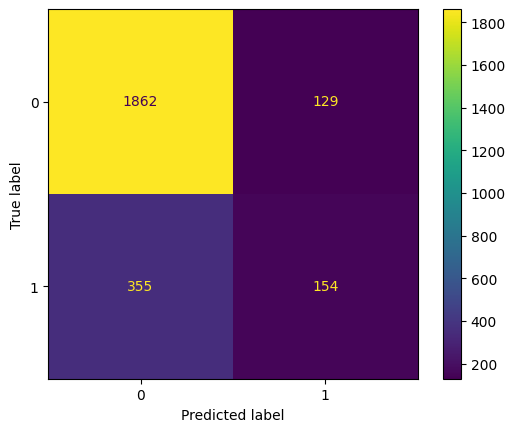

In [29]:
conf_matrix_plot(gnb_scaled, X_test, y_test)

The model metrics can be derived from the confusion matrix, and each metric tells its own part of the story. What stands out most in the confusion matrix is that the model misses a lot of customers who will churn. There are a lot of false negatives, **355**. This is why the recall score is only **0.303**. 